# Laura_Cavenati_864000_assignment4

## Introduction

L'obiettivo di questo assignment è quello di effettuare transfer learning utilizzando una CNN pre-addestrata su IMAGENET. L'architettura utilizzata è la VGG16.

La CNN viene utilizzata come features extractor con un nuovo task, la classificazione di immagini raffiguranti 4 diversi tipi di plastica: PET, HDPE, LDPE, PP.
Il dataset è stato preso da kaggle ([www.kaggle.com/piaoya/plastic-recycling-codes](https://www.kaggle.com/piaoya/plastic-recycling-codes)) e integrato con alcune immagini ottenute tramite web scraping.  

Come modello di classificazione è stato scelto una Support Vector Machine.

## Librarie

In [1]:
import numpy as np
import pandas as pd

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import vgg16
from tensorflow.keras.models import Model

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler# utile solo se faccio minmax
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

In [2]:
from google.colab import drive
import os
drive.mount('/content/drive', force_remount=True)
os.chdir('/content/drive/MyDrive/MAGISTRALE/2 anno/1 semestre/advanced machine learning/Assignment 4/plastics/train')

Mounted at /content/drive


#Importazione dei dati
Vengono caricante tutte le immagini che in origine si presentano non etichettate ma contenute all’interno di cartelle nominate con il nome dell’etichetta a loro assegnata. Per questa ragione è stata realizzata una funzione per importare i dati etichettandoli con il nome delle cartelle in cui sono contenuti.
Le immmagini vengono poi riscalate in modo che abbiano un formato 224x224 rgb.

In [3]:
#Inizialization
data = []
y = []

def import_data(value):
    for img in os.listdir(value):
      path = os.path.join(value, img)
      img=image.load_img(path, target_size=(224,224)) #load and resize
      data.append(np.array(img))  #dataset
      y.append(value) #target variable

for i in os.listdir():
  import_data(i)  # import data

# Esplorazione

Il dataset è composto da 4 cartelle, ciascuna contenente immagini relative a plastiche diverse:
1. polyethylene terephthalate (PET)
2. high-density polyethylene (HDPE) 
3. polyvinyl chloride (PVC)
4. low-density polyethylene (LDPE)
5. polypropylene (PP)
6. polystyrene (PS)

Il dataset è relativamente piccolo, è composto da 472 immagini. Queste immagini rappresentano 4 tipi diversi di plastiche, ritratte in situazioni differenti: fotografate direttamente dal creatore del dataset (quindi con angolazioni, luminosità, formati differenti) oppure prese in internet (e quindi per lo più  disegni fatti a computer).

La distribuzione delle classi all’interno del dataset è visualizzabile nel grafico sottostante.

In [4]:
len(data)

472

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


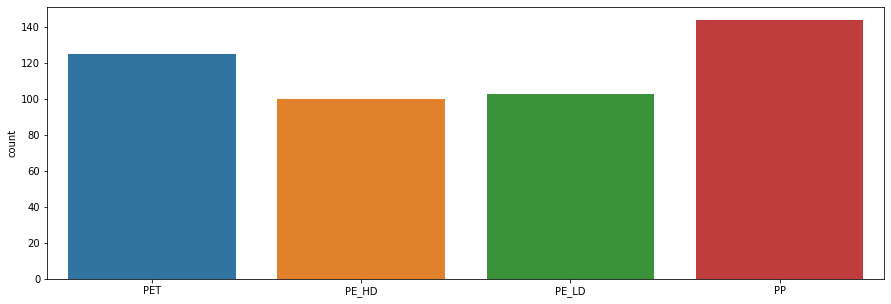

In [5]:
#classes distribution
plt.figure(figsize = (15, 5))
sns.countplot(y)

Le classi non sono bilanciate.  
Adesso rappresento alcuni simboli per avere un'idea delle immagini considerate

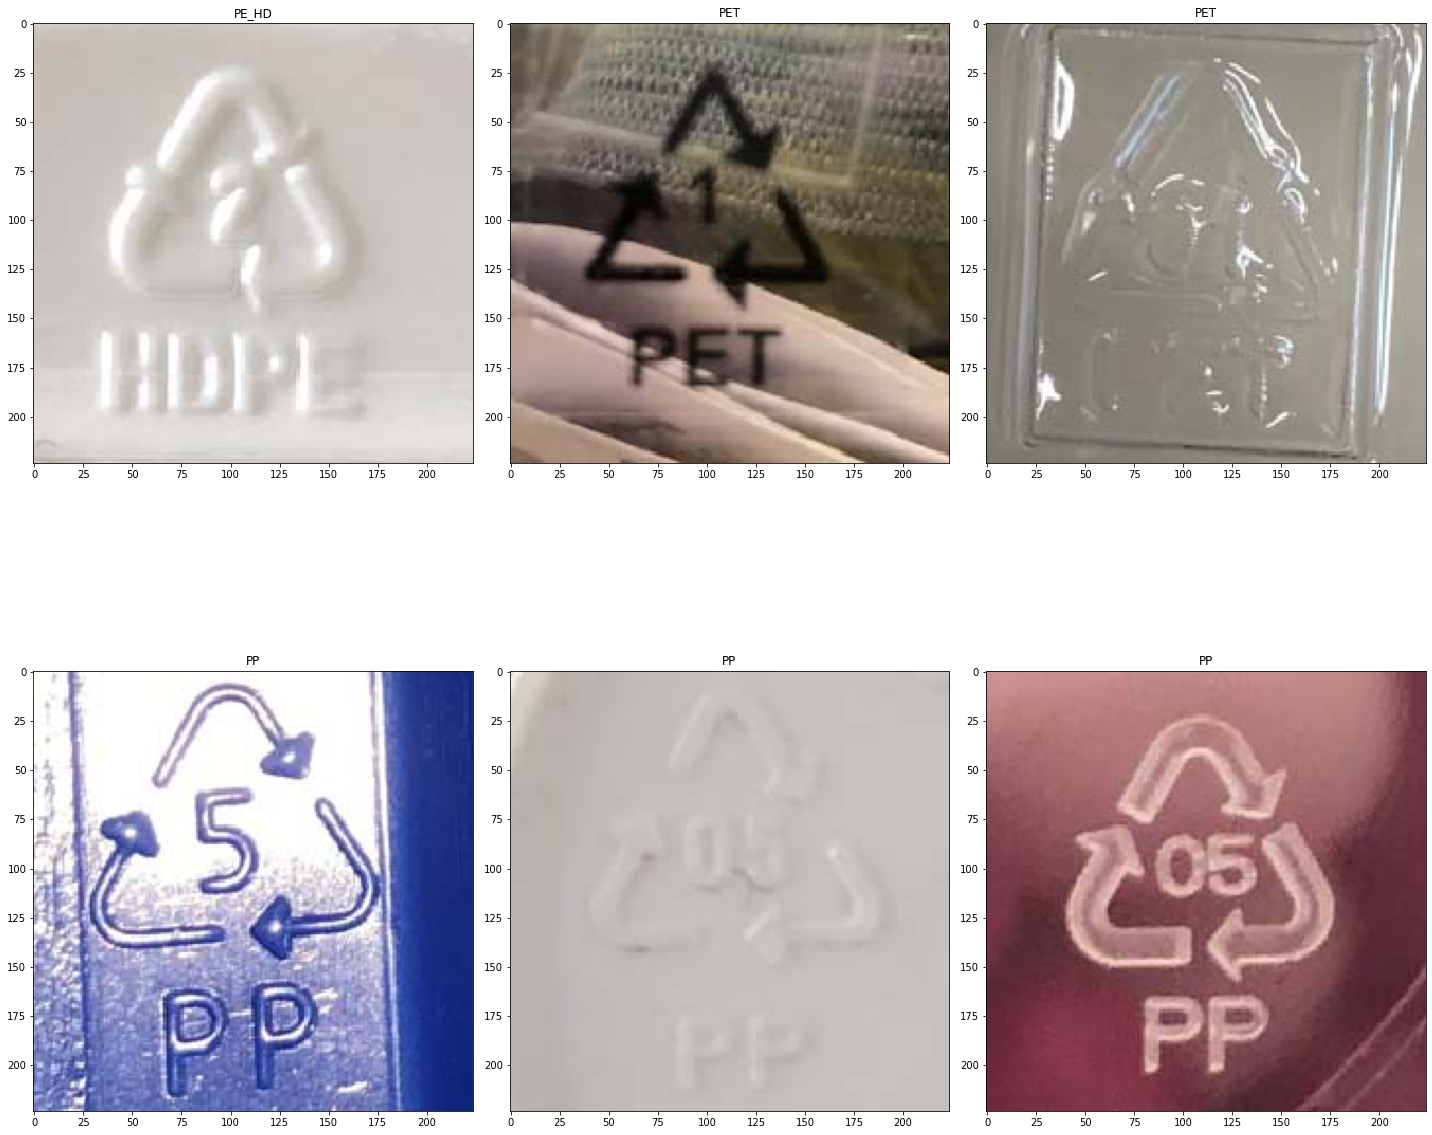

In [6]:
import random as rn
fig, ax = plt.subplots(2, 3, figsize = (30, 30))
fig.set_size_inches(20, 20)
for i in range(2):
    for j in range (3):
        l = rn.randint(0,len(y))
        ax[i, j].imshow(data[l])
        ax[i, j].set_title(y[l])
plt.tight_layout()            

# Preprocessing e features extraction
La variabile target viene trasformata in modo che diventi una variabile numerica. I dati, che inizialmente presentano l'ordine di lettura, sono stati mescolati in modo casuale.  
Attraverso il modulo *preprocess_input* vengono scalati i valori dei pixel in modo coerente con il preprocessing che hanno ricevuto le immagini del dataset imagenet su cui è stato addestrato il base_model.  
Successivamente vengono definite alcune funzioni che estraggono le features dalla rete convoluzionale e applicano ad esse delle trasformazioni (reshape, standardizzazione nel range [0, 1]).
Con l’obiettivo di ridurre la dimensionalità delle features è stata effettuata una PCA in modo da conservare l’80% della varianza spiegata.


In [7]:
y = LabelEncoder().fit_transform(y)
data = np.array(data)

#shuffle
idx = np.random.permutation(len(data))
data, y = data[idx], y[idx]

data= preprocess_input(data)

In [8]:
#array initialization
accuracy_train_TOT=[]
accuracy_test_TOT=[]
name=[]

In [9]:
#I load the VGG16 model with the pretrained weights for the imagenet dataset.
base_model = VGG16(input_shape=(224,224,3), weights='imagenet')
base_model.summary()

#PCA definition
pca = PCA(0.8, copy = False)

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [10]:
def feature_extraction(name_layer, data, base_model, pca):
  '''Extract and transform features from an Arbitrary Intermediate Layer (name_layer) with VGG16'''
  model = Model(inputs=base_model.input, outputs=base_model.get_layer(name=name_layer).output);  #new model cut
  print('')

  features = model.predict(data)
  features= features_transform(features)
  features = pca.fit_transform(features)
  return features

In [11]:
def features_transform(features):
  '''Transform features (reshape features and max-min scaler)'''
  shape=features.shape
  if len(shape)>2:    #(correct but not general)
    features=features.reshape((shape[0], shape[1]*shape[2]*shape[3]))
  scaler = MinMaxScaler(feature_range=[0, 1])
  features = scaler.fit_transform(features)
  return features

# Modelli
Sono stati creati 6 modelli basati sulle features estratte tagliando la rete in 6 diversi layers: block1_pool, block2_pool, block3_pool, block4_pool, block5_pool e fc1.  
Le features prodotte sono, nell’ordine: 802816, 401408, 200704, 100352, 25088 e 4096.  
I 6 modelli di classificazione realizzati sono stati ottimizzati nei loro iper-parametri attraverso un meccanismo di grid search, così da massimizzarne le prestazioni:  
• C: [0.1, 1, 10, 15, 30, 100]  
• kernel: [rbf, linear, poly, sigmoid]  
• gamma: [auto, scale]

In [12]:
def accuracy_test(x_train, x_test, y_train, y_test, accuracy_train_TOT, accuracy_test_TOT):
  '''Definition and train of support vector classifier'''
  param_grid = {'C': [0.1, 1, 10, 15, 30, 100], 'gamma': ['auto', 'scale'], 'kernel': ['rbf']} 
  m = GridSearchCV(SVC(class_weight = 'balanced'), param_grid = param_grid, cv = 20, n_jobs = -1) 
  m.fit(x_train, y_train)
  print("Best C value: {C}\nBest gamma value: {gamma}\nBest kernel value: {kernel}\n".format(C = m.best_params_['C'], gamma = m.best_params_['gamma'], kernel = m.best_params_['kernel']))

  y_pred_train= m.predict(x_train)
  accuracy_train=accuracy_score(y_train, y_pred_train)
  accuracy_train_TOT.append(accuracy_train)
  print('TRAIN')
  print(classification_report(y_train, y_pred_train, digits = 3))

  y_pred_test = m.predict(x_test)
  accuracy_test=accuracy_score(y_test, y_pred_test)
  accuracy_test_TOT.append(accuracy_test)
  print('TEST')
  print(classification_report(y_test, y_pred_test, digits = 3))


In [13]:
name_layer='block1_pool'
name.append(name_layer)
features=feature_extraction(name_layer, data, base_model, pca)
x_train, x_test, y_train, y_test = train_test_split(features, y, test_size = .25, stratify = y)  
accuracy_test(x_train, x_test, y_train, y_test, accuracy_train_TOT, accuracy_test_TOT)


Best C value: 1
Best gamma value: scale
Best kernel value: rbf

TRAIN
              precision    recall  f1-score   support

           0      0.716     0.723     0.720        94
           1      0.629     0.747     0.683        75
           2      0.739     0.844     0.788        77
           3      0.707     0.537     0.611       108

    accuracy                          0.698       354
   macro avg      0.698     0.713     0.700       354
weighted avg      0.700     0.698     0.693       354

TEST
              precision    recall  f1-score   support

           0      0.485     0.516     0.500        31
           1      0.472     0.680     0.557        25
           2      0.455     0.385     0.417        26
           3      0.407     0.306     0.349        36

    accuracy                          0.458       118
   macro avg      0.455     0.472     0.456       118
weighted avg      0.452     0.458     0.448       118



In [14]:
name_layer='block2_pool'
name.append(name_layer)
features=feature_extraction(name_layer, data, base_model, pca)
x_train, x_test, y_train, y_test = train_test_split(features, y, test_size = .25, stratify = y)  
accuracy_test(x_train, x_test, y_train, y_test, accuracy_train_TOT, accuracy_test_TOT)


Best C value: 10
Best gamma value: scale
Best kernel value: rbf

TRAIN
              precision    recall  f1-score   support

           0      1.000     0.947     0.973        94
           1      0.804     0.987     0.886        75
           2      1.000     0.974     0.987        77
           3      0.969     0.880     0.922       108

    accuracy                          0.941       354
   macro avg      0.943     0.947     0.942       354
weighted avg      0.949     0.941     0.942       354

TEST
              precision    recall  f1-score   support

           0      0.633     0.613     0.623        31
           1      0.560     0.560     0.560        25
           2      0.425     0.654     0.515        26
           3      0.565     0.361     0.441        36

    accuracy                          0.534       118
   macro avg      0.546     0.547     0.535       118
weighted avg      0.551     0.534     0.530       118



In [15]:
name_layer='block3_pool'
name.append(name_layer)
features=feature_extraction(name_layer, data, base_model, pca)
x_train, x_test, y_train, y_test = train_test_split(features, y, test_size = .25, stratify = y)  
accuracy_test(x_train, x_test, y_train, y_test, accuracy_train_TOT, accuracy_test_TOT)


Best C value: 15
Best gamma value: scale
Best kernel value: rbf

TRAIN
              precision    recall  f1-score   support

           0      1.000     0.979     0.989        94
           1      0.915     1.000     0.955        75
           2      1.000     1.000     1.000        77
           3      0.990     0.944     0.967       108

    accuracy                          0.977       354
   macro avg      0.976     0.981     0.978       354
weighted avg      0.979     0.977     0.978       354

TEST
              precision    recall  f1-score   support

           0      0.704     0.613     0.655        31
           1      0.630     0.680     0.654        25
           2      0.455     0.577     0.508        26
           3      0.581     0.500     0.537        36

    accuracy                          0.585       118
   macro avg      0.592     0.592     0.589       118
weighted avg      0.596     0.585     0.587       118



In [16]:
name_layer='block4_pool'
name.append(name_layer)
features=feature_extraction(name_layer, data, base_model, pca)
x_train, x_test, y_train, y_test = train_test_split(features, y, test_size = .25, stratify = y)  
accuracy_test(x_train, x_test, y_train, y_test, accuracy_train_TOT, accuracy_test_TOT)


Best C value: 10
Best gamma value: scale
Best kernel value: rbf

TRAIN
              precision    recall  f1-score   support

           0      1.000     0.957     0.978        94
           1      0.882     1.000     0.938        75
           2      1.000     1.000     1.000        77
           3      0.990     0.935     0.962       108

    accuracy                          0.969       354
   macro avg      0.968     0.973     0.969       354
weighted avg      0.972     0.969     0.969       354

TEST
              precision    recall  f1-score   support

           0      0.765     0.839     0.800        31
           1      0.783     0.720     0.750        25
           2      0.647     0.846     0.733        26
           3      0.889     0.667     0.762        36

    accuracy                          0.763       118
   macro avg      0.771     0.768     0.761       118
weighted avg      0.780     0.763     0.763       118



In [17]:
name_layer='block5_pool'
name.append(name_layer)
features=feature_extraction(name_layer, data, base_model, pca)
x_train, x_test, y_train, y_test = train_test_split(features, y, test_size = .25, stratify = y)  
accuracy_test(x_train, x_test, y_train, y_test, accuracy_train_TOT, accuracy_test_TOT)


Best C value: 10
Best gamma value: auto
Best kernel value: rbf

TRAIN
              precision    recall  f1-score   support

           0      1.000     0.957     0.978        94
           1      0.938     1.000     0.968        75
           2      1.000     1.000     1.000        77
           3      0.981     0.972     0.977       108

    accuracy                          0.980       354
   macro avg      0.980     0.982     0.981       354
weighted avg      0.981     0.980     0.980       354

TEST
              precision    recall  f1-score   support

           0      0.576     0.613     0.594        31
           1      0.462     0.480     0.471        25
           2      0.481     0.500     0.491        26
           3      0.688     0.611     0.647        36

    accuracy                          0.559       118
   macro avg      0.552     0.551     0.550       118
weighted avg      0.565     0.559     0.561       118



In [18]:
name_layer='fc1'
name.append(name_layer)
features=feature_extraction(name_layer, data, base_model, pca)
x_train, x_test, y_train, y_test = train_test_split(features, y, test_size = .25, stratify = y) 
accuracy_test(x_train, x_test, y_train, y_test, accuracy_train_TOT, accuracy_test_TOT)


Best C value: 15
Best gamma value: scale
Best kernel value: rbf

TRAIN
              precision    recall  f1-score   support

           0      1.000     1.000     1.000        94
           1      1.000     1.000     1.000        75
           2      1.000     1.000     1.000        77
           3      1.000     1.000     1.000       108

    accuracy                          1.000       354
   macro avg      1.000     1.000     1.000       354
weighted avg      1.000     1.000     1.000       354

TEST
              precision    recall  f1-score   support

           0      0.656     0.677     0.667        31
           1      0.708     0.680     0.694        25
           2      0.560     0.538     0.549        26
           3      0.676     0.694     0.685        36

    accuracy                          0.653       118
   macro avg      0.650     0.648     0.649       118
weighted avg      0.652     0.653     0.652       118



# Risultati e conclusioni


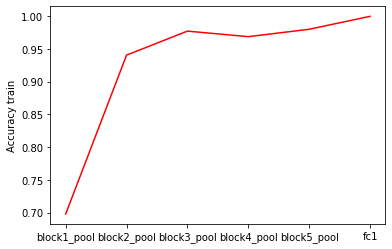

In [19]:
df_train=pd.DataFrame({"name": tuple(name),
                   "accuracy": tuple(accuracy_train_TOT)})

plt.ylabel('Accuracy train')
plt.plot(df_train['name'], df_train['accuracy'], color = 'red')

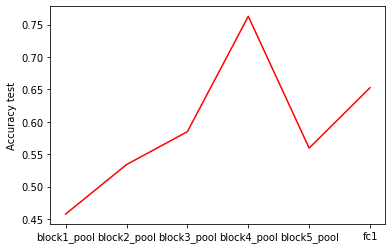

In [20]:
df_test=pd.DataFrame({"name": tuple(name),
                   "accuracy": tuple(accuracy_test_TOT)})

plt.ylabel('Accuracy test')
plt.plot(df_test['name'], df_test['accuracy'], color = 'red')

Nonostante sia stata applicata una cross validazione, per tutti i modelli sembra esserci overfitting. Sicuramente per avere prestazioni più performanti bisognerebbe aumentare il dataset.  
L'ultimo modello realizzato, che è il migliore in termini di accuracy sul train set, è quello costruito partendo dalle features estratte dal layer fc1, ovvero quello più vicino , tra quelli presi in esame, alla coda della rete. I modelli precedenti, realizzati con l’obiettivo di risalire la rete per verificare l’eventuale impatto positivo di features più generiche estratte dalle immagini, hanno prodotto delle prestazioni nel train set inferiori.  
Se guardiamo le prestazioni nel test set invece, il modello migliore è quello costruito partendo dalle features estratte dal layer block4_pool. I modelli precedenti, ottenuti partendo da features più generiche, sono meno capaci di spiegare la variabilità delle immagini. I modelli successivi, ottenuti partendo da features più sppecifiche, invece si specializzano troppo e perdono capacità di generalizzare e rapppresentare bene le immagini.


Sembrerebbe quindi che le features estratte in mezzo alla rete risultino più esplicative rispetto a quelle più generiche prodotte nella parte iniziale della VGG16. Ciò potrebbe essere dovuto al fatto che all’interno del dataset IMAGENET sono presenti, tra le tantissime immagini, anche lettere e numeri che costituiscono i simboli dei tipi di platica.
Per ottenere risultati più precisi però, bisognerebbe migliorare e aumentare il dataset.